In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import re
import random
import unicodedata
import pickle
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.word2count = {}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.n_words = 4

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


In [14]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = open('fra-eng.txt', encoding='utf-8').read().strip().split('\n')

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 15

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

In [7]:
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [15]:
try:
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
    print(random.choice(pairs))
except FileNotFoundError:
    print("Downloading French-English dataset...")
    import urllib.request
    url = "https://download.pytorch.org/tutorial/data.zip"
    urllib.request.urlretrieve(url, "data.zip")
    import zipfile
    with zipfile.ZipFile("data.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    os.rename("data/eng-fra.txt", "fra-eng.txt")
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
    print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 12823 sentence pairs
Counting words...
Counted words:
fra 5036
eng 3310
['elle est francaise .', 'she is french .']


In [16]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang):
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        input_tensor = self.tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self.tensorFromSentence(self.output_lang, pair[1])
        return input_tensor, target_tensor

    def indexesFromSentence(self, lang, sentence):
        return [lang.word2index.get(word, lang.word2index["<UNK>"]) for word in sentence.split(' ')]

    def tensorFromSentence(self, lang, sentence):
        indexes = self.indexesFromSentence(lang, sentence)
        indexes.append(lang.word2index["<EOS>"])
        return torch.tensor(indexes, dtype=torch.long, device=device)

In [17]:
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    input_tensors, target_tensors = zip(*batch)

    input_lengths = [len(tensor) for tensor in input_tensors]
    target_lengths = [len(tensor) for tensor in target_tensors]

    max_input_len = max(input_lengths)
    max_target_len = max(target_lengths)

    padded_inputs = torch.zeros(len(batch), max_input_len, dtype=torch.long, device=device)
    padded_targets = torch.zeros(len(batch), max_target_len, dtype=torch.long, device=device)

    for i, (input_tensor, target_tensor) in enumerate(batch):
        padded_inputs[i, :len(input_tensor)] = input_tensor
        padded_targets[i, :len(target_tensor)] = target_tensor

    return padded_inputs, padded_targets, input_lengths, target_lengths


In [18]:
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

train_dataset = TranslationDataset(train_pairs, input_lang, output_lang)
test_dataset = TranslationDataset(test_pairs, input_lang, output_lang)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers,
                         dropout=dropout, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seqs, input_lengths):
        embedded = self.dropout(self.embedding(input_seqs))

        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, batch_first=True, enforce_sorted=True)
        outputs, hidden = self.gru(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        outputs = self.fc(outputs)

        hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
        hidden = hidden[-1]
        hidden = torch.tanh(self.fc(torch.cat([hidden[0], hidden[1]], dim=1)))
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)

        return outputs, hidden


In [20]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        batch_size = encoder_outputs.size(0)
        max_len = encoder_outputs.size(1)

        hidden = hidden[-1].unsqueeze(1).repeat(1, max_len, 1)

        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], dim=2)))
        attention = self.v(energy).squeeze(2)

        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)

        return F.softmax(attention, dim=1)

In [21]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=2, dropout=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers,
                         dropout=dropout, batch_first=True)
        self.out = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_step, last_hidden, encoder_outputs, mask=None):
        embedded = self.dropout(self.embedding(input_step))

        attn_weights = self.attention(last_hidden, encoder_outputs, mask)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)

        rnn_input = torch.cat([embedded, context], dim=2)
        output, hidden = self.gru(rnn_input, last_hidden)

        output = self.out(torch.cat([output.squeeze(1), context.squeeze(1)], dim=1))

        return output, hidden, attn_weights


In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size, device=device)
        attentions = torch.zeros(batch_size, trg_len, src.size(1), device=device)

        encoder_outputs, hidden = self.encoder(src, src_len)

        mask = (src != 0).float()

        input_step = trg[:, 0].unsqueeze(1)

        for t in range(1, trg_len):
            output, hidden, attn_weights = self.decoder(input_step, hidden, encoder_outputs, mask)
            outputs[:, t] = output
            attentions[:, t] = attn_weights

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_step = trg[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)

        return outputs, attentions


In [23]:
INPUT_DIM = input_lang.n_words
OUTPUT_DIM = output_lang.n_words
HID_DIM = 256
N_LAYERS = 2
DROPOUT = 0.5

encoder = EncoderRNN(INPUT_DIM, HID_DIM, N_LAYERS, DROPOUT)
decoder = AttnDecoderRNN(HID_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder).to(device)

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,055,854 trainable parameters


In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [26]:
def train_epoch(model, data_loader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for batch_idx, (src, trg, src_len, trg_len) in enumerate(data_loader):
        optimizer.zero_grad()

        output, _ = model(src, src_len, trg)

        output_dim = output.shape[-1]
        output = output[:, 1:].contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(data_loader)}, Loss: {loss.item():.4f}')

    return epoch_loss / len(data_loader)

In [27]:
def evaluate_epoch(model, data_loader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg, src_len, trg_len in data_loader:
            output, _ = model(src, src_len, trg, 0)

            output_dim = output.shape[-1]
            output = output[:, 1:].contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

In [28]:
N_EPOCHS = 20
CLIP = 1

train_losses = []
valid_losses = []

In [29]:
for epoch in range(N_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate_epoch(model, test_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tVal Loss: {valid_loss:.3f}')

Batch 0/321, Loss: 8.1074
Batch 100/321, Loss: 3.7156
Batch 200/321, Loss: 3.4786
Batch 300/321, Loss: 3.0848
Epoch: 01
	Train Loss: 3.612
	Val Loss: 3.061
Batch 0/321, Loss: 3.0384
Batch 100/321, Loss: 2.6447
Batch 200/321, Loss: 2.2217
Batch 300/321, Loss: 2.7300
Epoch: 02
	Train Loss: 2.621
	Val Loss: 2.637
Batch 0/321, Loss: 2.1119
Batch 100/321, Loss: 2.7373
Batch 200/321, Loss: 2.0022
Batch 300/321, Loss: 2.1384
Epoch: 03
	Train Loss: 2.129
	Val Loss: 2.500
Batch 0/321, Loss: 1.6116
Batch 100/321, Loss: 1.7582
Batch 200/321, Loss: 1.7761
Batch 300/321, Loss: 1.6973
Epoch: 04
	Train Loss: 1.795
	Val Loss: 2.315
Batch 0/321, Loss: 1.4150
Batch 100/321, Loss: 1.1239
Batch 200/321, Loss: 1.5266
Batch 300/321, Loss: 1.6486
Epoch: 05
	Train Loss: 1.560
	Val Loss: 2.269
Batch 0/321, Loss: 1.5106
Batch 100/321, Loss: 1.3866
Batch 200/321, Loss: 1.5536
Batch 300/321, Loss: 1.3148
Epoch: 06
	Train Loss: 1.370
	Val Loss: 2.233
Batch 0/321, Loss: 1.1680
Batch 100/321, Loss: 1.3038
Batch 200/

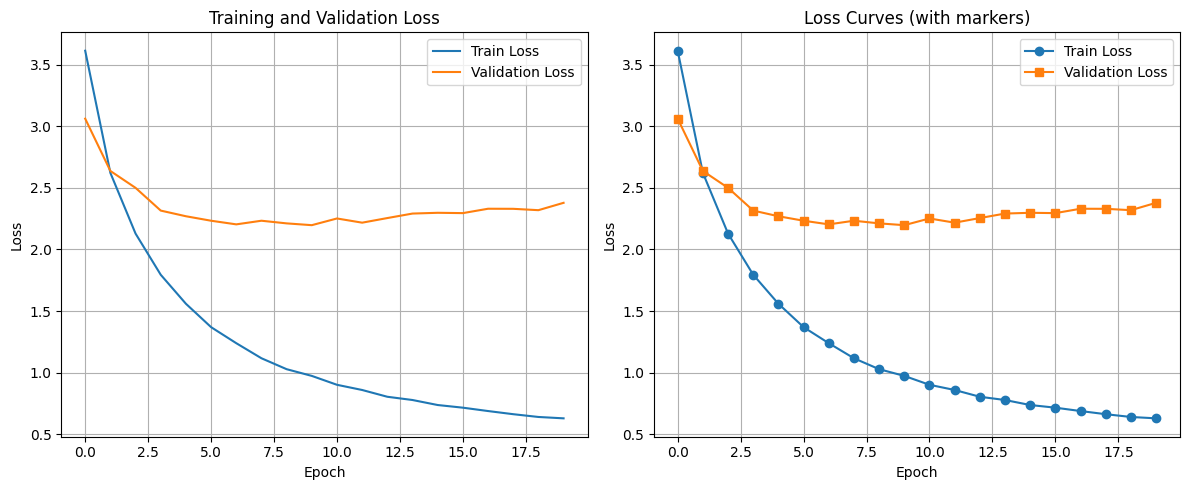

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(valid_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves (with markers)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
def translate_sentence(model, sentence, input_lang, output_lang, max_length=MAX_LENGTH):
    model.eval()

    with torch.no_grad():
        tokens = [input_lang.word2index.get(word, input_lang.word2index["<UNK>"])
                 for word in sentence.lower().split()]
        tokens.append(input_lang.word2index["<EOS>"])

        src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
        src_len = [len(tokens)]

        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

        mask = (src_tensor != 0).float()

        trg_indexes = [output_lang.word2index["<SOS>"]]
        attentions = torch.zeros(max_length, len(tokens), device=device)

        for i in range(max_length):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).unsqueeze(0).to(device)

            with torch.no_grad():
                output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
                attentions[i] = attention.squeeze(0)

            pred_token = output.argmax(1).item()
            trg_indexes.append(pred_token)

            if pred_token == output_lang.word2index["<EOS>"]:
                break

        trg_tokens = [output_lang.index2word[i] for i in trg_indexes[1:]]

        return trg_tokens, attentions[:len(trg_tokens), :len(tokens)]

In [32]:
def display_attention(sentence, translation, attentions, input_lang_name='French', output_lang_name='English'):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)

    cax = ax.matshow(attentions.cpu().numpy(), cmap='Blues')
    fig.colorbar(cax)

    input_tokens = sentence.split(' ') + ['<EOS>']
    output_tokens = translation

    ax.set_xticklabels([''] + input_tokens, rotation=90)
    ax.set_yticklabels([''] + output_tokens)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.xlabel(f'Input ({input_lang_name})')
    plt.ylabel(f'Output ({output_lang_name})')
    plt.title('Attention Weights Visualization')
    plt.tight_layout()
    plt.show()


Input: Je suis étudiant
Output: m a .


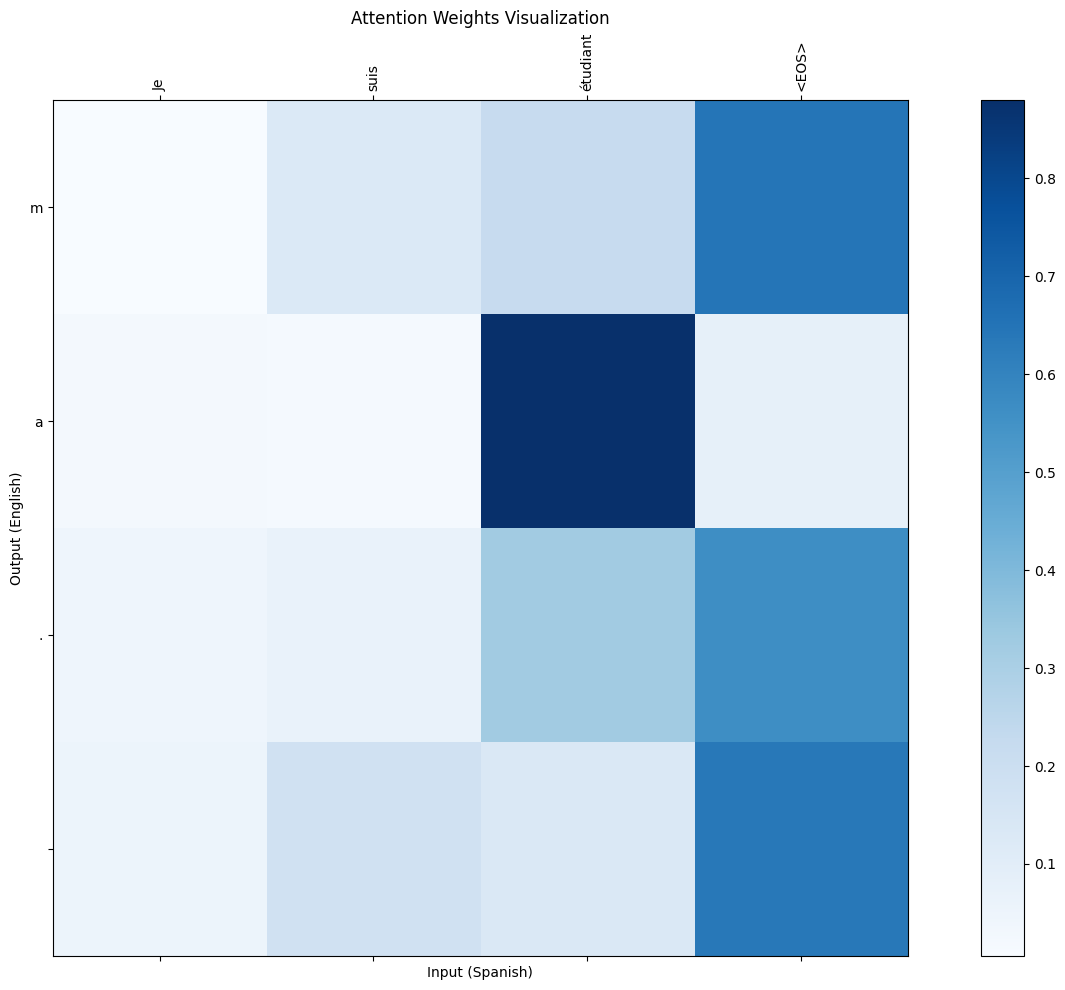

Input: il est très intelligent
Output: m a smart .


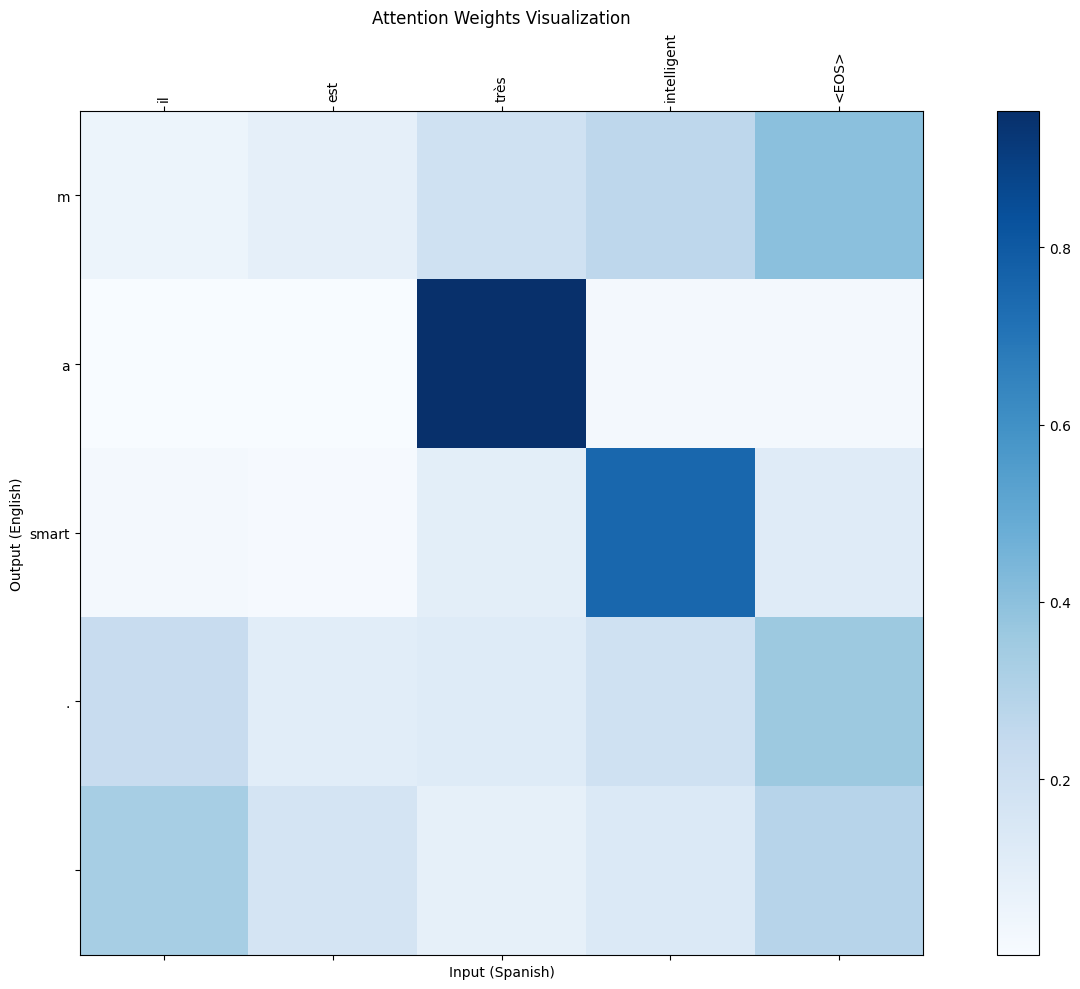

Input: elle est à la maison
Output: is a only line .


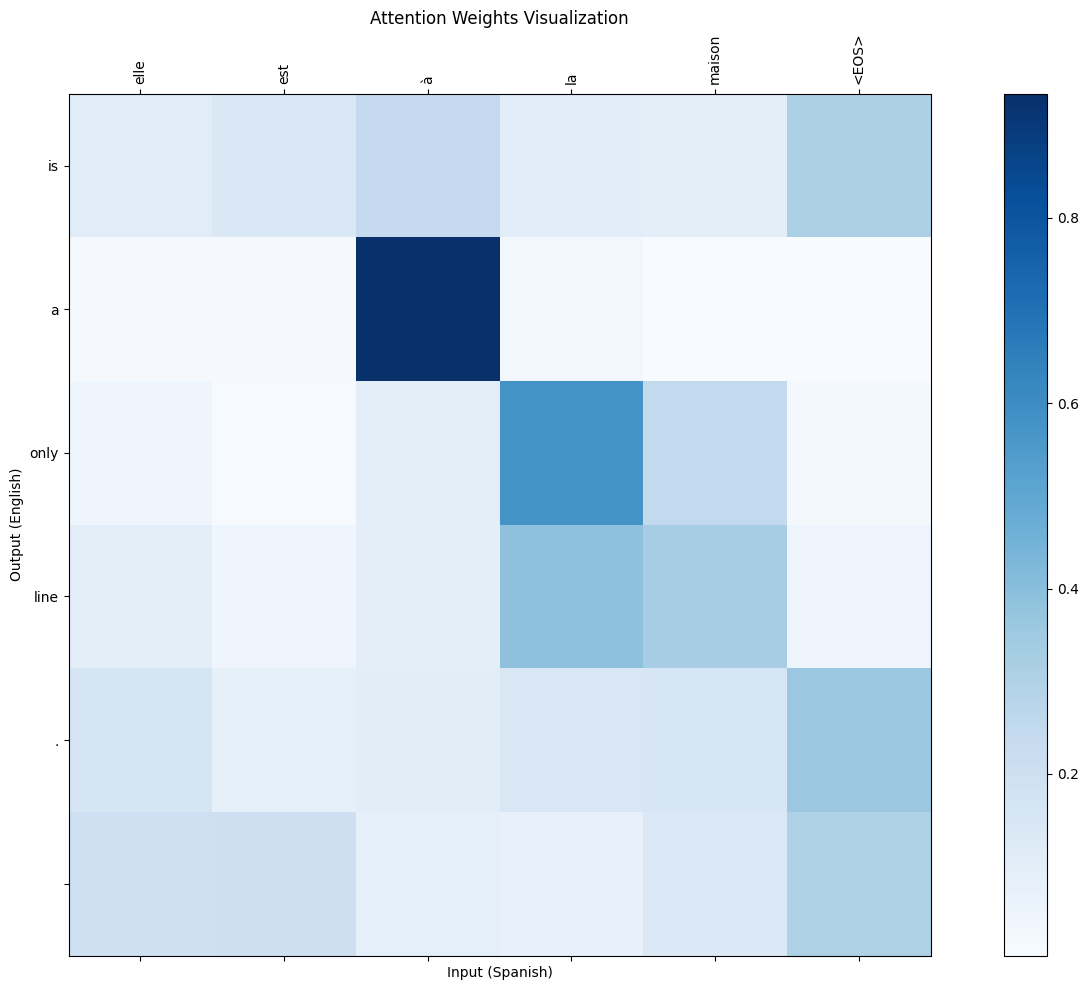

In [33]:
def evaluate_and_show_attention(sentence):
    output_words, attentions = translate_sentence(model, sentence, input_lang, output_lang)
    output_sentence = ' '.join(output_words[:-1]) if output_words[-1] == '<EOS>' else ' '.join(output_words)

    print(f'Input: {sentence}')
    print(f'Output: {output_sentence}')

    display_attention(sentence, output_words[:-1] if output_words[-1] == '<EOS>' else output_words, attentions)

test_sentences = [
    "Je suis étudiant",
    "il est très intelligent",
    "elle est à la maison"
]

for sentence in test_sentences:
    evaluate_and_show_attention(sentence)

In [34]:
def calculate_bleu_score(model, test_pairs, input_lang, output_lang, max_samples=100):
    model.eval()
    translations = []
    references = []

    for i, (src_sentence, trg_sentence) in enumerate(test_pairs[:max_samples]):
        if i % 20 == 0:
            print(f'Translating {i}/{max_samples}...')

        translation, _ = translate_sentence(model, src_sentence, input_lang, output_lang)
        translation = [word for word in translation if word not in ['<EOS>', '<SOS>', '<PAD>']]

        reference = trg_sentence.split()

        translations.append(translation)
        references.append([reference])

    return translations, references

In [35]:
translations, references = calculate_bleu_score(model, test_pairs, input_lang, output_lang)

Translating 0/100...
Translating 20/100...
Translating 40/100...
Translating 60/100...
Translating 80/100...


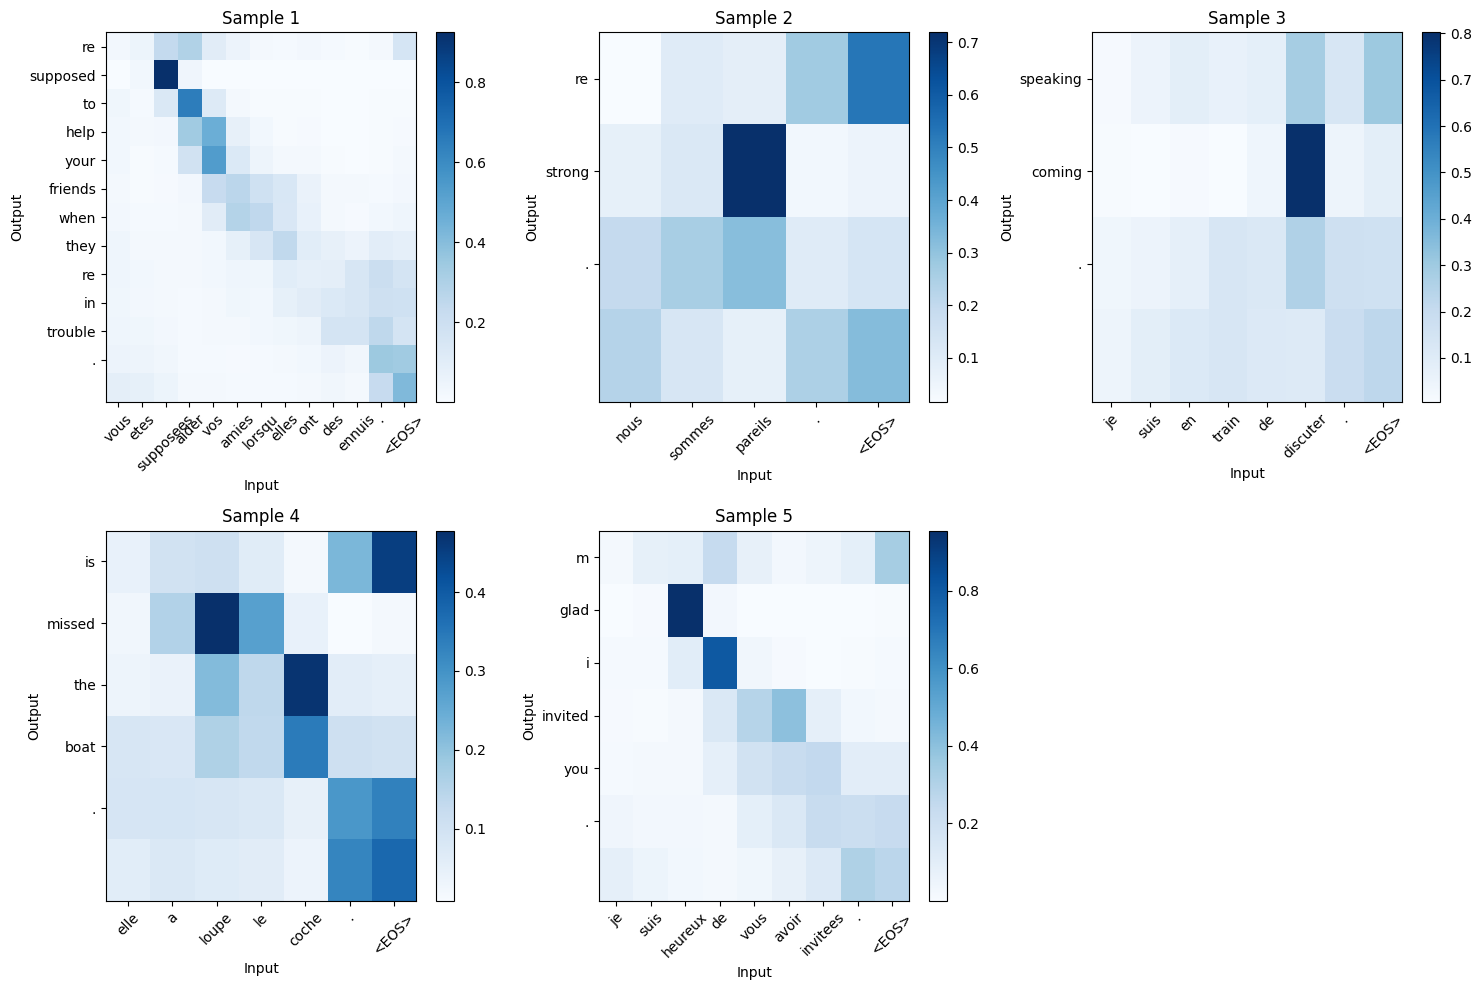

In [36]:
plt.figure(figsize=(15, 10))

attention_heatmap_data = []
sample_pairs = random.sample(test_pairs, 5)

for i, (src_sentence, trg_sentence) in enumerate(sample_pairs):
    translation, attentions = translate_sentence(model, src_sentence, input_lang, output_lang)

    plt.subplot(2, 3, i+1)
    plt.imshow(attentions.cpu().numpy(), cmap='Blues', aspect='auto')
    plt.colorbar()

    src_tokens = src_sentence.split()[:attentions.size(1)-1] + ['<EOS>']
    trg_tokens = translation[:-1] if translation[-1] == '<EOS>' else translation

    plt.xticks(range(len(src_tokens)), src_tokens, rotation=45)
    plt.yticks(range(len(trg_tokens)), trg_tokens)
    plt.title(f'Sample {i+1}')
    plt.xlabel('Input')
    plt.ylabel('Output')

plt.tight_layout()
plt.show()

In [37]:
vocab_sizes = [input_lang.n_words, output_lang.n_words]
vocab_names = ['French', 'English']

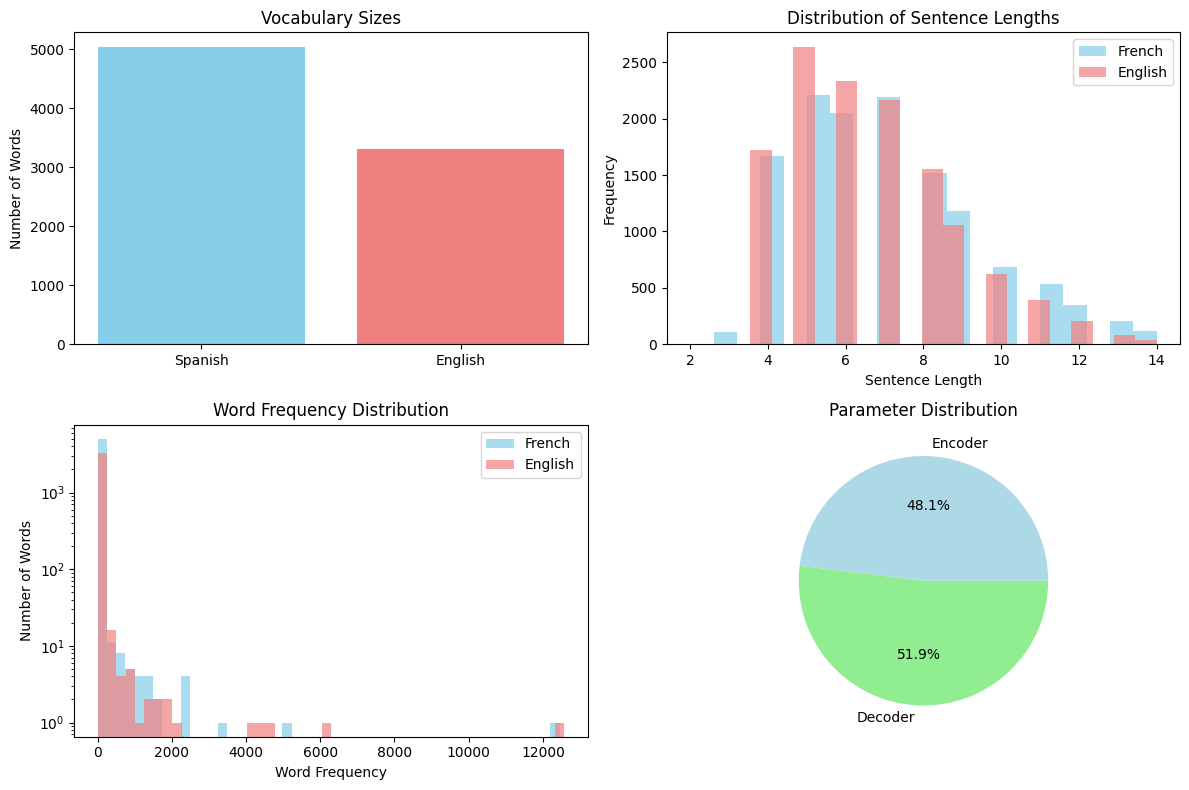

In [40]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(vocab_names, vocab_sizes, color=['skyblue', 'lightcoral'])
plt.title('Vocabulary Sizes')
plt.ylabel('Number of Words')

plt.subplot(2, 2, 2)
sentence_lengths_src = [len(pair[0].split()) for pair in pairs]
sentence_lengths_trg = [len(pair[1].split()) for pair in pairs]

plt.hist(sentence_lengths_src, bins=20, alpha=0.7, label='French', color='skyblue')
plt.hist(sentence_lengths_trg, bins=20, alpha=0.7, label='English', color='lightcoral')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.legend()

plt.subplot(2, 2, 3)
word_counts_src = list(input_lang.word2count.values())
word_counts_trg = list(output_lang.word2count.values())

plt.hist(word_counts_src, bins=50, alpha=0.7, label='French', color='skyblue')
plt.hist(word_counts_trg, bins=50, alpha=0.7, label='English', color='lightcoral')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Word Frequency Distribution')
plt.legend()
plt.yscale('log')

plt.subplot(2, 2, 4)
model_params = {
    'Encoder': count_parameters(model.encoder),
    'Decoder': count_parameters(model.decoder)
}
plt.pie(model_params.values(), labels=model_params.keys(), autopct='%1.1f%%',
        colors=['lightblue', 'lightgreen'])
plt.title('Parameter Distribution')

plt.tight_layout()
plt.show()


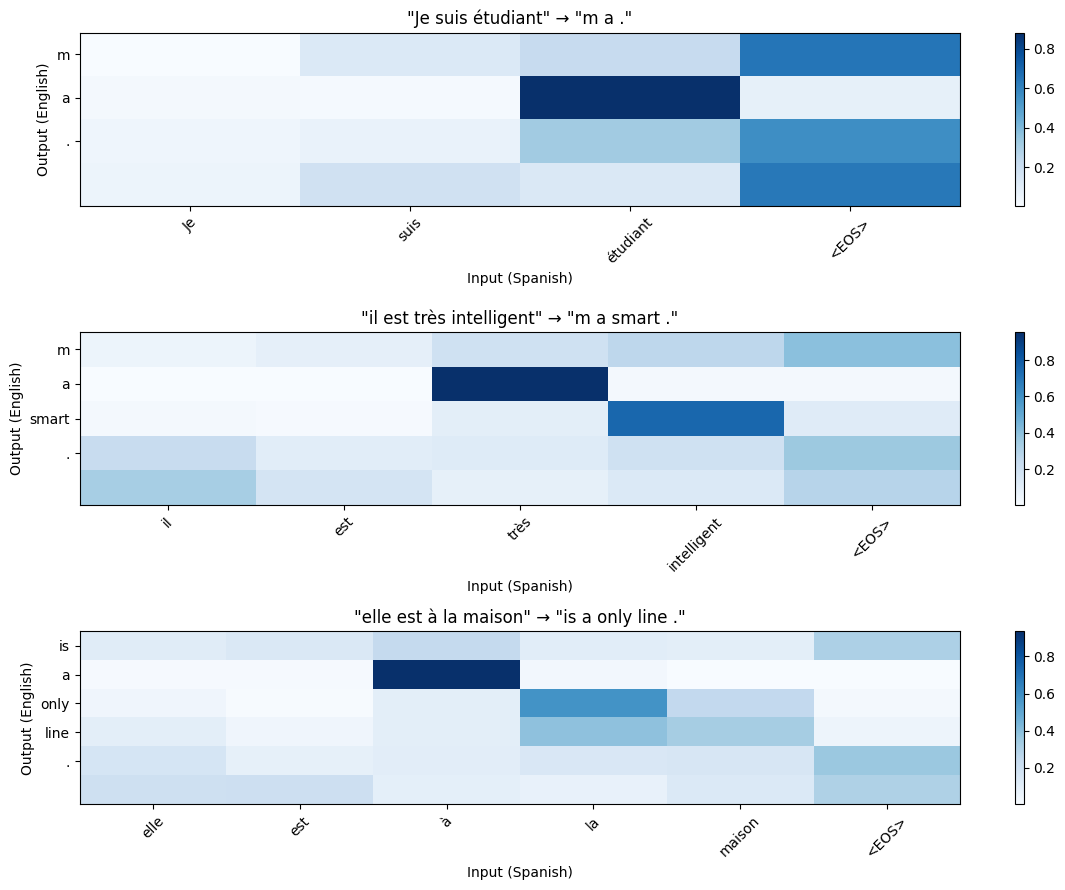

In [39]:
attention_analysis_sentences = [
    "Je suis étudiant",
    "il est très intelligent",
    "elle est à la maison"
]

fig, axes = plt.subplots(len(attention_analysis_sentences), 1, figsize=(12, 3*len(attention_analysis_sentences)))

for idx, sentence in enumerate(attention_analysis_sentences):
    translation, attentions = translate_sentence(model, sentence, input_lang, output_lang)

    ax = axes[idx] if len(attention_analysis_sentences) > 1 else axes

    im = ax.imshow(attentions.cpu().numpy(), cmap='Blues', aspect='auto')

    src_tokens = sentence.split() + ['<EOS>']
    trg_tokens = translation[:-1] if translation and translation[-1] == '<EOS>' else translation

    ax.set_xticks(range(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=45)
    ax.set_yticks(range(len(trg_tokens)))
    ax.set_yticklabels(trg_tokens)

    ax.set_title(f'"{sentence}" → "{" ".join(trg_tokens)}"')
    ax.set_xlabel('Input (French)')
    ax.set_ylabel('Output (English)')

    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()